In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [2]:
train = pd.read_csv("/Users/martinyeh/Desktop/DeepLearning_WU/myproject/CNN/dataset/sign_mnist_train.csv")
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [3]:
X_train = X_train / 255.0
print("x_train shape: ",X_train.shape)
print("y_train shape: ",Y_train.shape)

x_train shape:  (27455, 784)
y_train shape:  (27455,)


In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_val shape",Y_val.shape)

x_train shape (24709, 784)
x_val shape (2746, 784)
y_train shape (24709,)
y_val shape (2746,)


In [5]:
X_train = X_train.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("x_val shape: ",X_val.shape)

x_train shape:  (24709, 28, 28, 1)
x_val shape:  (2746, 28, 28, 1)


In [6]:
Y_train = to_categorical(Y_train, num_classes = 25)
Y_val_label = Y_val
Y_val = to_categorical(Y_val, num_classes = 25)
print("y_train shape: ",Y_train.shape)
print("y_val shape: ",Y_val.shape)

y_train shape:  (24709, 25)
y_val shape:  (2746, 25)


In [7]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    
    return X

In [9]:
def ResNet50(input_shape = (28, 28, 1), classes = 25):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((2, 2))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # AVGPOOL (≈1 line).
    X = AveragePooling2D(pool_size=(2, 2))(X)


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [10]:
model = ResNet50(input_shape = (28, 28, 1), classes = 25)

In [11]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 13, 13, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 13, 13, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(X_train, Y_train,validation_data=(X_val, Y_val), epochs = 10, batch_size = 32)


Train on 24709 samples, validate on 2746 samples
Epoch 1/10
24709/24709 [==============================] - 414s 17ms/step - loss: 1.0629 - accuracy: 0.7487 - val_loss: 0.9361 - val_accuracy: 0.8809
Epoch 2/10
24709/24709 [==============================] - 402s 16ms/step - loss: 0.1639 - accuracy: 0.9579 - val_loss: 3.0312 - val_accuracy: 0.4796
Epoch 3/10
24709/24709 [==============================] - 433s 18ms/step - loss: 0.1415 - accuracy: 0.9726 - val_loss: 0.5507 - val_accuracy: 0.8725
Epoch 4/10
24709/24709 [==============================] - 400s 16ms/step - loss: 0.0570 - accuracy: 0.9868 - val_loss: 0.3559 - val_accuracy: 0.9126
Epoch 5/10
24709/24709 [==============================] - 397s 16ms/step - loss: 0.0129 - accuracy: 0.9964 - val_loss: 9.2431e-05 - val_accuracy: 1.0000
Epoch 6/10
24709/24709 [==============================] - 395s 16ms/step - loss: 0.1154 - accuracy: 0.9772 - val_loss: 1.0200 - val_accuracy: 0.8361
Epoch 7/10
24709/24709 [============================

In [14]:
metrics = pd.DataFrame(model.history.history)
metrics

,val_loss,val_accuracy,loss,accuracy
0,0.936145,0.880918,1.062859,0.748675
1,3.031221,0.479607,0.163887,0.957910
2,0.550748,0.872542,0.141479,0.972642
3,0.355853,0.912600,0.056970,0.986806
4,0.000092,1.000000,0.012866,0.996439
5,1.020019,0.836125,0.115435,0.977215
6,0.007317,0.997451,0.052539,0.988709
7,1.249281,0.722141,0.074125,0.983650
8,0.126657,0.966497,0.018112,0.995629
9,0.046295,0.985433,0.032279,0.993484


In [15]:
metrics.columns

Index(['val_loss', 'val_accuracy', 'loss', 'accuracy'], dtype='object')

<AxesSubplot:>

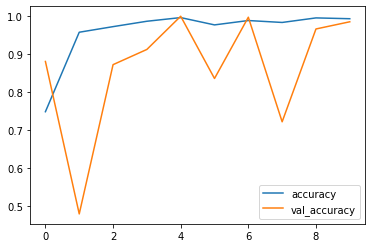

In [16]:
metrics[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

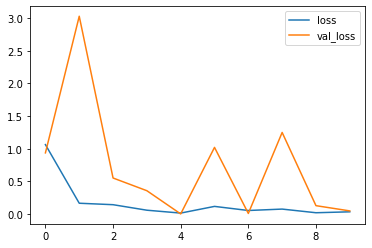

In [17]:
metrics[['loss','val_loss']].plot()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

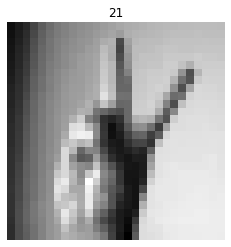

In [19]:
test1 = pd.read_csv("/Users/martinyeh/Desktop/DeepLearning_WU/myproject/CNN/dataset/sign_mnist_test.csv")
X_test1 = test1.drop(labels = ["label"],axis = 1)
img = X_test1.iloc[5].values
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(test1.iloc[5,0])
plt.axis("off")
plt.show()

In [20]:
X_test1=X_test1/ 255.0
x = X_test1.iloc[5].values.reshape((-1,28,28,1))
print("class prediction vector = ")
print(model.predict(x))
tmp = list(model.predict(x)[0])
y_answer = tmp.index(max(tmp))
print("Your algorithm predicts: y = "+str(y_answer))


class prediction vector = 
[[5.1241382e-06 4.8878547e-08 4.0314154e-07 3.1083028e-04 4.8546549e-09
  2.3033008e-05 5.2345247e-04 1.8136042e-07 1.7820379e-06 2.0498517e-06
  2.6010550e-06 8.0635236e-06 3.8217868e-06 1.5865834e-06 2.6046976e-07
  3.3850274e-06 9.7687064e-08 1.3549003e-04 9.7273332e-05 1.8208354e-03
  3.2703643e-05 9.9628180e-01 4.4783173e-04 9.5687965e-06 2.8789215e-04]]
Your algorithm predicts: y = 21


In [21]:
# X_test2 = test1.drop(labels = ["label"],axis = 1)
# X_test2 = X_test2/255.0
# Y_test2 = test1["label"]
# X_test2 = X_test2.values.reshape(-1,28,28,1)
pred = model.predict(X_val)
result = []
for i in range(len(pred)):
    tmp = list(pred[i])
    y_answer = tmp.index(max(tmp))
    result.append(y_answer)

print(classification_report(Y_val_label.values, result))
confusion_matrix(Y_val_label.values, result)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       107
           3       1.00      0.99      1.00       126
           4       1.00      0.99      0.99        96
           5       1.00      1.00      1.00       132
           6       0.94      1.00      0.97       118
           7       0.93      1.00      0.97        99
           8       1.00      1.00      1.00       117
          10       0.99      1.00      1.00       110
          11       1.00      1.00      1.00       129
          12       1.00      0.90      0.95       101
          13       0.85      1.00      0.92       112
          14       1.00      1.00      1.00       118
          15       1.00      1.00      1.00       127
          16       1.00      1.00      1.00       114
          17       0.99      1.00      1.00       110
          18       1.00    

array([[106,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 100,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 107,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 125,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  95,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 132,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 118,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0